In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("WELFake_Dataset.csv")

In [3]:
df = df.fillna('')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       72134 non-null  object
 2   text        72134 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
df

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [7]:
df.isnull().value_counts()

title  text   label
False  False  False    72134
Name: count, dtype: int64

In [8]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

<Axes: xlabel='label', ylabel='count'>

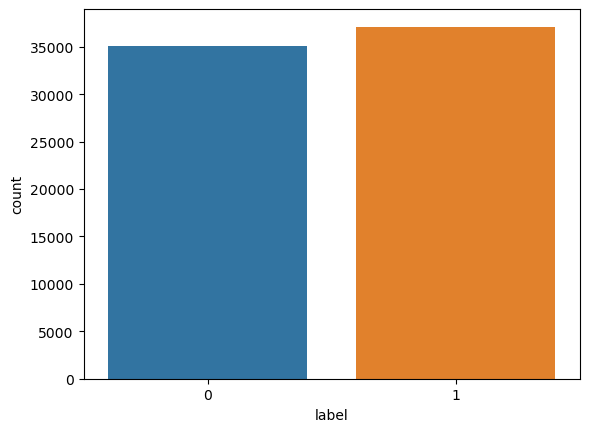

In [9]:
import seaborn as sns

sns.countplot(data=df, x='label')

In [10]:
df['label'].value_counts()

label
1    37106
0    35028
Name: count, dtype: int64

In [11]:
for col in df.columns:
    print(col, ':', df[col].nunique())

title : 62348
text : 62719
label : 2


In [12]:
any_nan = df.isnull().any().any()

# Display the result
print(f"Are there any NaN values in the DataFrame? {any_nan}")
df

Are there any NaN values in the DataFrame? False


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [13]:
# Combining title and text
df['content'] = df['title'] + ' ' + df['text']

# Drop rows with missing values
df.dropna(inplace=True)

## Upsampling the minority class

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [14]:

from sklearn.utils import resample

df_majority = df[df['label']==1]
df_minority = df[df['label']==0]

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)
df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [15]:
df_upsampled[df_upsampled['label']==0].shape


(37106, 4)

In [16]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['label']==0].iloc[:29000]
positive_data_points_train = df_upsampled[df_upsampled['label']==1].iloc[:29000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['label']==0].iloc[29000:]
positive_data_points_test = df_upsampled[df_upsampled['label']==1].iloc[29000:]
## Concatenate the training positive and negative contents
X_train = pd.concat([positive_data_points_train['content'], negative_data_points_train['content']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train['label'], negative_data_points_train['label']])

## Concatenating the test positive and negative contents
X_test = pd.concat([positive_data_points_test['content'], negative_data_points_test['content']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test['label'], negative_data_points_test['label']])


In [17]:
y_train.value_counts()

label
1    29000
0    29000
Name: count, dtype: int64

In [18]:
y_test.value_counts()

label
1    8106
0    8106
Name: count, dtype: int64

## Pre-process the reviews: 

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, we implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. 

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deepthikondragunta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
# TASK CELL
import re
import string

def remove_stopwords(text):
    temp=[]
    for word in text.split():
        if word in stopwords.words('english'):
            temp.append('')
        else:
            temp.append(word)
    x=temp[:]
    temp.clear()
    return " ".join(x)

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    review_cleaned=review.lower() #converting the reviews to lowercase
    review_cleaned=re.sub(r'<.*?>','',review_cleaned)  #the html tags are replaced with the empty strings
    review_cleaned=re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', review_cleaned) #removing URL's form the text
    #removing punctuations form the text
    exclude=string.punctuation
    review_cleaned=review_cleaned.translate(str.maketrans('','',exclude))
    review_cleaned=remove_stopwords(review_cleaned) #calling an external function that removes the stopwords from each review.
    ps=PorterStemmer() #initializing the porter stemmer object
    review_cleaned=" ".join([ps.stem(word) for word in review_cleaned.split()])
    return review_cleaned

In [21]:
X_train.iloc[0]

'Early Clinton Email Witness Was Never Interviewed by FBI: Project Veritas \nProject Veritas Action has just released a new video relating to the investigations of Hillary Clintonâ€™s private email servers.\nIn December, 2010, US Department of State IT Systems Administrator Cindy Almodovar reported that she met with Huma Abedin for thirty minutes regarding emails at the then unknown, but now notorious, @clintoneail.com site. Hereâ€™s is the text from that email exchange:\nFrom: Almodovar, Cindy T\nSent: Friday, December 17, 2010 11:17 AM\nTo: SES-IRM_Tech\nCc: SES-IRM_FO-Mgt\nSubject: Meeting with Huma\nI met with Huma for about 30 minutes to go over mail issues.\nShe gave me some examples listed below, but also, things are inconsistent. But issue #1 is of an e-mail which was sent to her twice this morning, did get received on but was not delivered. See details below.\nI have a contact for the @clintonemail site, his name is Bryan Pagliano and he actually now works for State, but he ap

In [22]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

earli clinton email wit never interview fbi project verita project verita action releas new video relat investig hillari clintonâ€™ privat email server decemb 2010 us depart state system administr cindi almodovar report met huma abedin thirti minut regard email unknown notori clintoneailcom site hereâ€™ text email exchang almodovar cindi sent friday decemb 17 2010 1117 sesirmtech cc sesirmfomgt subject meet huma met huma 30 minut go mail issu gave exampl list also thing inconsist issu 1 email sent twice morn get receiv deliv see detail contact clintonemail site name bryan pagliano actual work state appar set huma sent sever test clintonemail account lona â€“ receiv mani messag respons receiv sent messag morn stategov account cheftwanmailhousegov â§ recipi respond didnâ€™t get respons found respons arriv â€œsubmit categorizerâ€ 647 morn â§ resent 711 sender huma receiv also â€œsubmit categorizerâ€ 1214 hdr22clintonemailcom sent messag humaclintonemailcom valmorolistategov 1003 pm subj

In [23]:
# Apply clean_review function to the training data
X_train= X_train.apply(clean_review)
# Apply clean_review function to the test data
X_test = X_test.apply(clean_review)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size=0.2, random_state=42)

In [ ]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [ ]:
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))
print("Accuracy:", round(accuracy_score(y_test, predicted)*100),'%')

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      8106
           1       0.93      0.82      0.87      8106

    accuracy                           0.88     16212
   macro avg       0.89      0.88      0.88     16212
weighted avg       0.89      0.88      0.88     16212

Accuracy: 88 %


In [ ]:
# def predict_fake_news(news):
#     prediction = model.predict([news])
#     return 'Fake' if prediction[0] == 0 else 'Real'
# # Example usage
# print(predict_fake_news("SATAN 2: Russia unvelis an image of its terrif."))

def predict_fake_news(news):
    # Clean the input news text
    cleaned_news = clean_review(news)
    
    # Make predictions using the model
    prediction = model.predict([cleaned_news])
    
    # Return the result as 'Fake' or 'Real'
    return 'Fake' if prediction[0] == 0 else 'Real'


In [ ]:

# Example usage
news_text = "SATAN 2: Russia unveils an image of its terrif."
print(predict_fake_news(news_text))


Real


In [ ]:
print(predict_fake_news("Ukraine is being invaded by russia."))

Real


In [ ]:
print(predict_fake_news("India won the fifa worldcup."))

Fake
